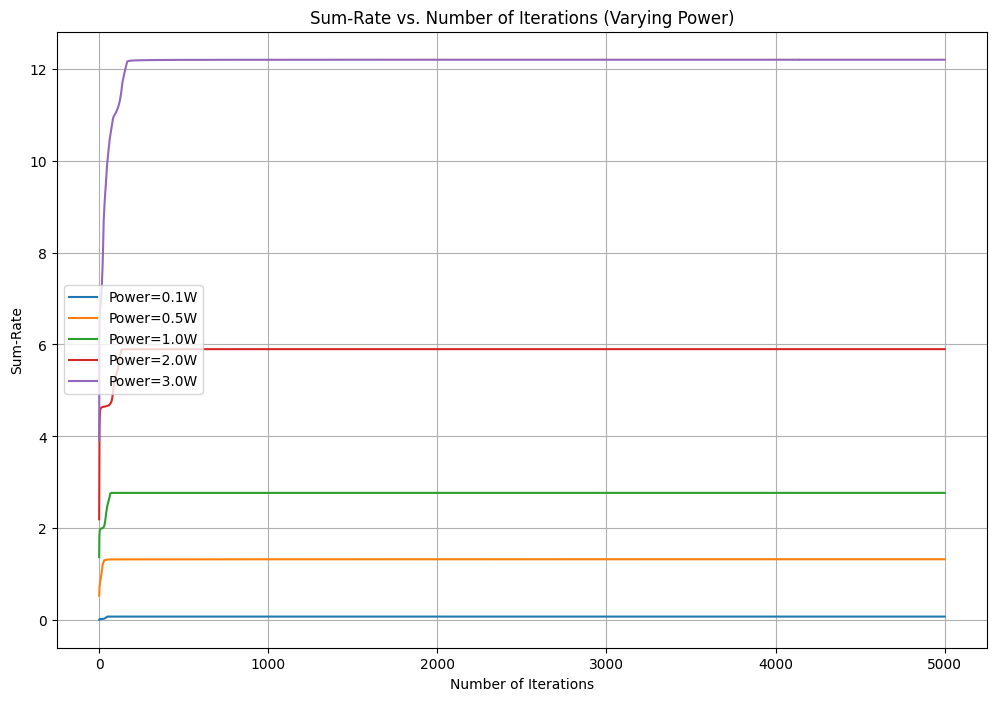

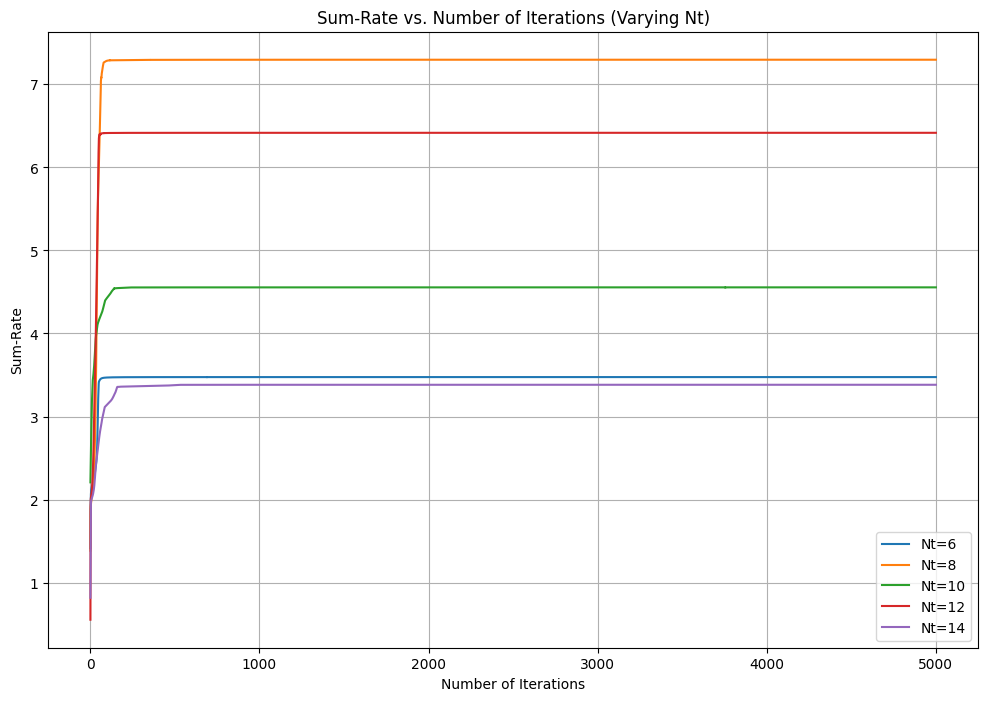

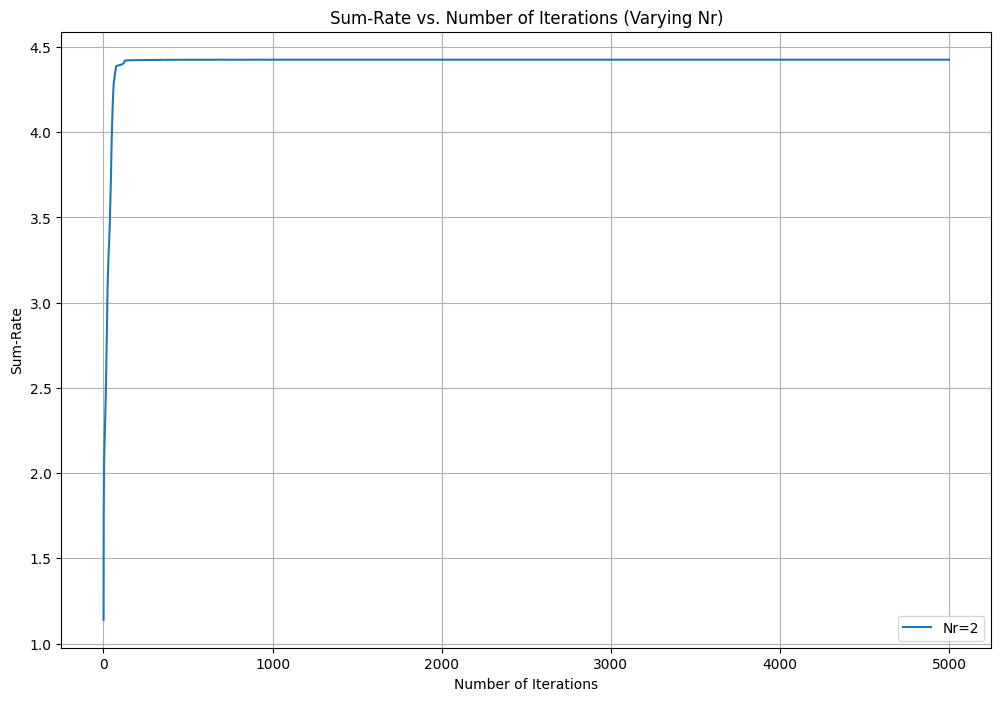

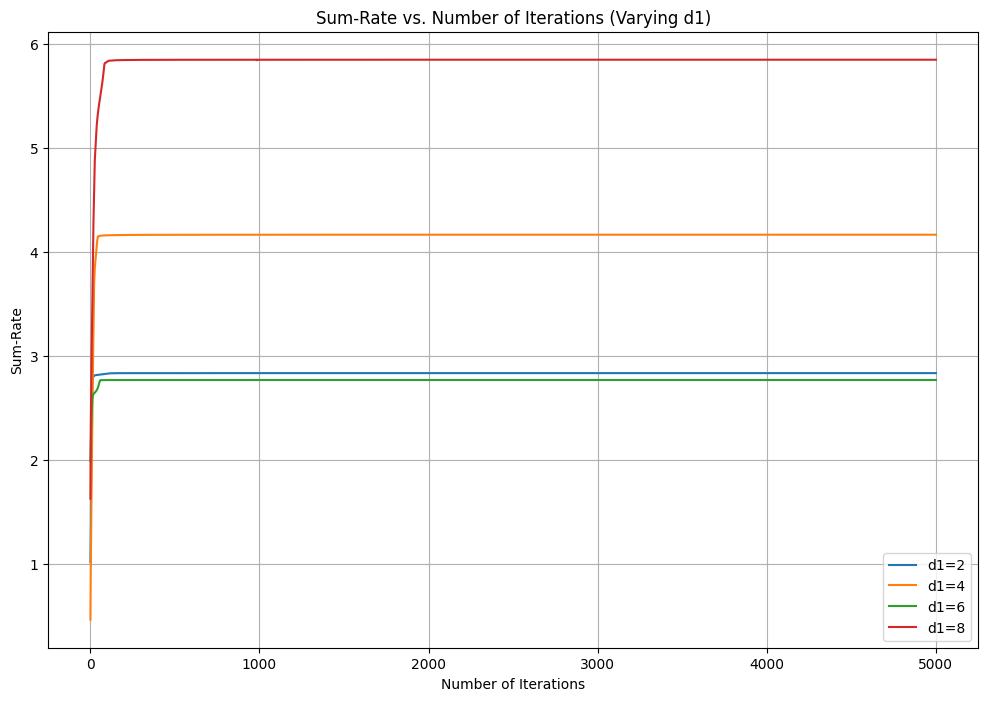

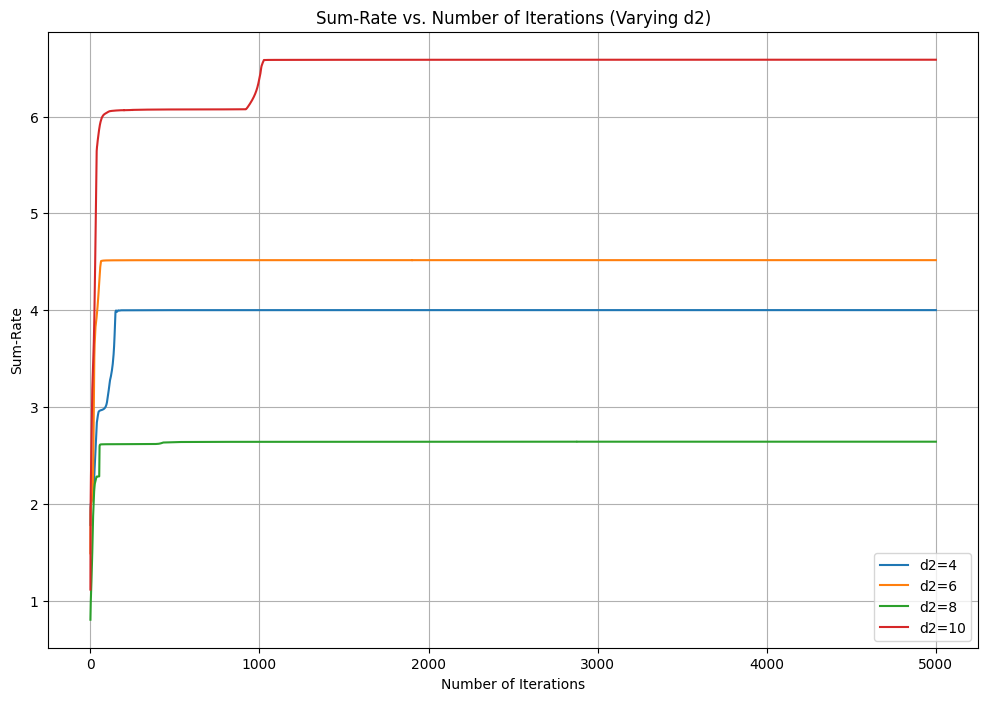

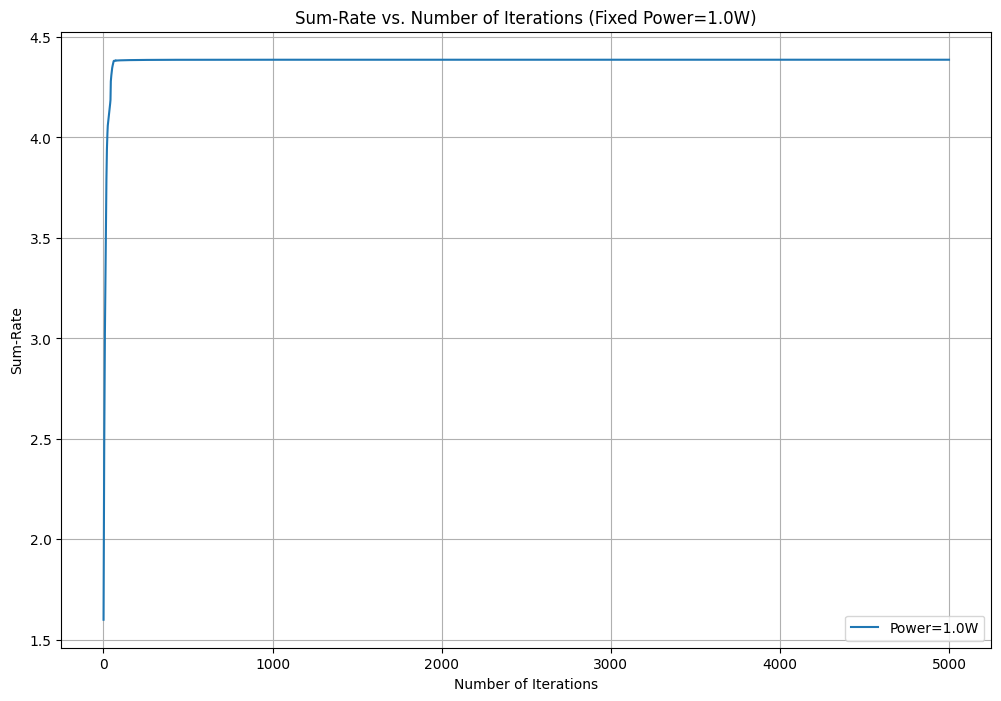

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt

# Set a fixed random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Define constants for noise power and number of users
NOISE_POWER = 1e-3  # Assume some noise power for simplicity
K = 2  # Number of users
T = 5000  # Number of iterations

# Encoder-Decoder Network
class EncoderDecoderModel(nn.Module):
    def __init__(self, Nt, Nr, d1, d2):
        super(EncoderDecoderModel, self).__init__()
        self.Nt = Nt
        self.Nr = Nr

        # Feature extraction layers for V and HV
        self.V_feature = nn.Linear(Nt * K, d1 * Nt * K)  # Adjust to match V dimensions
        self.HV_feature = nn.Linear(Nr * Nr, d2 * Nr * Nr)

        # MPNN Layers for learnable matrices
        self.fc1 = nn.Linear(d1 * Nt * K + d2 * Nr * Nr, 128)
        self.fc2 = nn.Linear(128, Nt * Nt)
        self.fc3 = nn.Linear(128, Nr * Nr)

    def forward(self, V, HV):
        # Flatten the matrices before passing through the layers
        V_flat = V.reshape(-1)
        HV_flat = HV.reshape(-1)

        # Extract features for V and HV
        V_feature = torch.relu(self.V_feature(V_flat))
        HV_feature = torch.relu(self.HV_feature(HV_flat))

        # Concatenate the features
        combined_features = torch.cat((V_feature, HV_feature), dim=-1)

        # Message Passing Neural Network (MPNN)
        x = torch.relu(self.fc1(combined_features))
        W_left = torch.relu(self.fc2(x)).reshape(self.Nt, self.Nt)
        W_right = torch.relu(self.fc3(x)).reshape(self.Nr, self.Nr)

        return W_left, W_right

# Update function for V
def update_precoding(V, H, W_left, W_right):
    return torch.matmul(torch.matmul(W_left, V), W_right)

# Sum-Rate Loss Function (Negative Sum-Rate)
def sum_rate_loss(V, H, power=1.0):
    sum_rate = 0
    for k in range(K):  # Iterate over each user
        # Signal power for user k, scale by transmission power
        signal = torch.matmul(H[k], V[:, k].unsqueeze(1)) * power
        signal_power = torch.norm(signal) ** 2

        # Interference power from other users
        interference_power = sum(
            torch.norm(torch.matmul(H[j], V[:, k].unsqueeze(1))) ** 2 for j in range(K) if j != k
        )

        # SINR for user k
        sinr_k = signal_power / (interference_power + NOISE_POWER)

        # Rate for user k
        rate_k = torch.log2(1 + sinr_k)
        sum_rate += rate_k

    # Negate the sum-rate to turn maximization into a minimization problem
    return -sum_rate

# Function to run training with varying power
def train_with_power_variation(power_values, Nt_fixed, Nr_fixed, d1_fixed, d2_fixed):
    plt.figure(figsize=(12, 8))

    for power in power_values:
        model = EncoderDecoderModel(Nt_fixed, Nr_fixed, d1_fixed, d2_fixed)
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        V = torch.rand((Nt_fixed, K), requires_grad=True)
        HV = torch.rand((Nr_fixed, Nr_fixed), requires_grad=True)
        H = torch.rand((K, Nr_fixed, Nt_fixed), requires_grad=True)

        losses = []

        for t in range(T):
            W_left, W_right = model(V, HV)
            V_updated = update_precoding(V, H, W_left, W_right)
            loss = sum_rate_loss(V_updated, H, power=power)

            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()

            losses.append(loss.item())

        plt.plot(range(1, T + 1), [-loss for loss in losses], label=f'Power={power}W')

    plt.xlabel('Number of Iterations')
    plt.ylabel('Sum-Rate')
    plt.title('Sum-Rate vs. Number of Iterations (Varying Power)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to run training with varying parameters
def train_with_parameter_variation(param_name, param_values, Nt_fixed, Nr_fixed, d1_fixed, d2_fixed, power_fixed=1.0):
    plt.figure(figsize=(12, 8))

    for value in param_values:
        if param_name == 'Nt':
            Nt, Nr, d1, d2 = value, Nr_fixed, d1_fixed, d2_fixed
        elif param_name == 'Nr':
            Nt, Nr, d1, d2 = Nt_fixed, value, d1_fixed, d2_fixed
        elif param_name == 'd1':
            Nt, Nr, d1, d2 = Nt_fixed, Nr_fixed, value, d2_fixed
        elif param_name == 'd2':
            Nt, Nr, d1, d2 = Nt_fixed, Nr_fixed, d1_fixed, value

        model = EncoderDecoderModel(Nt, Nr, d1, d2)
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        V = torch.rand((Nt, K), requires_grad=True)
        HV = torch.rand((Nr, Nr), requires_grad=True)
        H = torch.rand((K, Nr, Nt), requires_grad=True)

        losses = []

        for t in range(T):
            W_left, W_right = model(V, HV)
            V_updated = update_precoding(V, H, W_left, W_right)
            loss = sum_rate_loss(V_updated, H, power=power_fixed)

            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()

            losses.append(loss.item())

        plt.plot(range(1, T + 1), [-loss for loss in losses], label=f'{param_name}={value}')

    plt.xlabel('Number of Iterations')
    plt.ylabel('Sum-Rate')
    plt.title(f'Sum-Rate vs. Number of Iterations (Varying {param_name})')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to run training for fixed power
def train_fixed_power(Nt_fixed, Nr_fixed, d1_fixed, d2_fixed, power=1e-3):
    plt.figure(figsize=(12, 8))

    model = EncoderDecoderModel(Nt_fixed, Nr_fixed, d1_fixed, d2_fixed)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    V = torch.rand((Nt_fixed, K), requires_grad=True)
    HV = torch.rand((Nr_fixed, Nr_fixed), requires_grad=True)
    H = torch.rand((K, Nr_fixed, Nt_fixed), requires_grad=True)

    losses = []

    for t in range(T):
        W_left, W_right = model(V, HV)
        V_updated = update_precoding(V, H, W_left, W_right)
        loss = sum_rate_loss(V_updated, H, power=power)

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        losses.append(loss.item())

    plt.plot(range(1, T + 1), [-loss for loss in losses], label=f'Power={power}W')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Sum-Rate')
    plt.title(f'Sum-Rate vs. Number of Iterations (Fixed Power={power}W)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Run experiments
power_values = [0.1, 0.5, 1.0, 2.0, 3.0]
train_with_power_variation(power_values, Nt_fixed=8, Nr_fixed=2, d1_fixed=2, d2_fixed=4)

Nt_values = [6,8, 10, 12,14]
train_with_parameter_variation('Nt', Nt_values, Nt_fixed=8, Nr_fixed=2, d1_fixed=2, d2_fixed=4, power_fixed=1.0)

Nr_values = [2]
train_with_parameter_variation('Nr', Nr_values, Nt_fixed=8, Nr_fixed=2, d1_fixed=2, d2_fixed=4, power_fixed=1.0)

d1_values = [2, 4, 6, 8]
train_with_parameter_variation('d1', d1_values, Nt_fixed=8, Nr_fixed=2, d1_fixed=2, d2_fixed=4, power_fixed=1.0)

d2_values = [4, 6, 8, 10]
train_with_parameter_variation('d2', d2_values, Nt_fixed=8, Nr_fixed=2, d1_fixed=2, d2_fixed=4, power_fixed=1.0)

train_fixed_power(Nt_fixed=8, Nr_fixed=2, d1_fixed=2, d2_fixed=4, power=1.0)


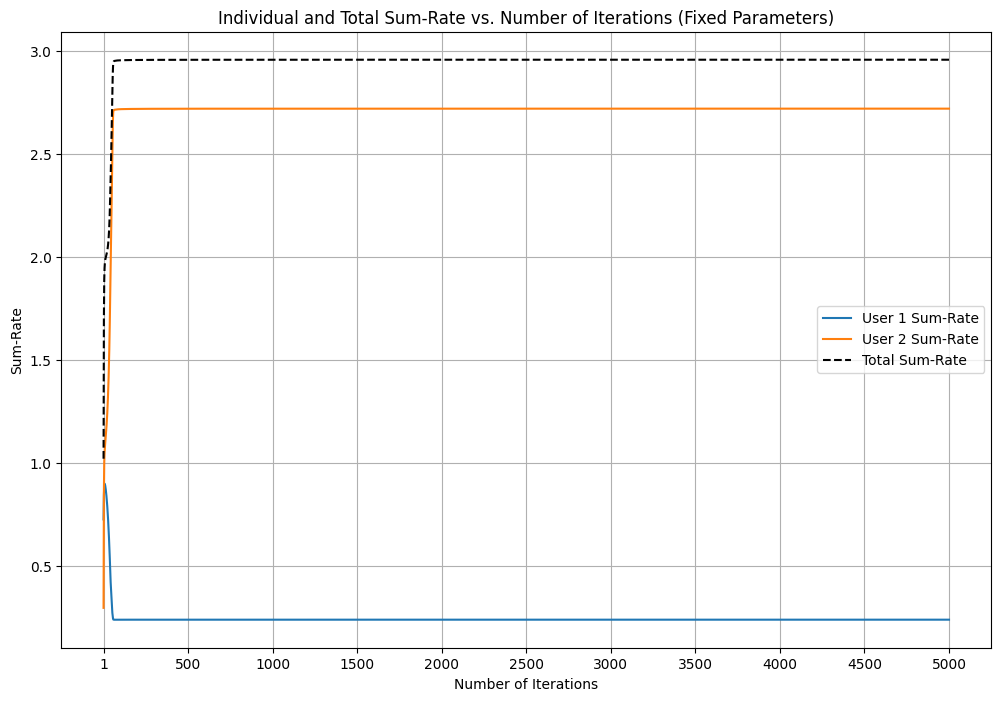

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt

# Set a fixed random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Define constants for noise power and number of users
NOISE_POWER = 1e-3  # Assume some noise power for simplicity
K = 2  # Number of users
T = 5000  # Number of iterations

# Encoder-Decoder Network
class EncoderDecoderModel(nn.Module):
    def __init__(self, Nt, Nr, d1, d2):
        super(EncoderDecoderModel, self).__init__()
        self.Nt = Nt
        self.Nr = Nr

        # Feature extraction layers for V and HV
        self.V_feature = nn.Linear(Nt * K, d1 * Nt * K)  # Adjust to match V dimensions
        self.HV_feature = nn.Linear(Nr * Nr, d2 * Nr * Nr)

        # MPNN Layers for learnable matrices
        self.fc1 = nn.Linear(d1 * Nt * K + d2 * Nr * Nr, 128)
        self.fc2 = nn.Linear(128, Nt * Nt)
        self.fc3 = nn.Linear(128, Nr * Nr)

    def forward(self, V, HV):
        # Flatten the matrices before passing through the layers
        V_flat = V.reshape(-1)
        HV_flat = HV.reshape(-1)

        # Extract features for V and HV
        V_feature = torch.relu(self.V_feature(V_flat))
        HV_feature = torch.relu(self.HV_feature(HV_flat))

        # Concatenate the features
        combined_features = torch.cat((V_feature, HV_feature), dim=-1)

        # Message Passing Neural Network (MPNN)
        x = torch.relu(self.fc1(combined_features))
        W_left = torch.relu(self.fc2(x)).reshape(self.Nt, self.Nt)
        W_right = torch.relu(self.fc3(x)).reshape(self.Nr, self.Nr)

        return W_left, W_right

# Update function for V
def update_precoding(V, H, W_left, W_right):
    return torch.matmul(torch.matmul(W_left, V), W_right)

# Sum-Rate per User Function
def sum_rate_per_user(V, H, power=1.0):
    user_sum_rates = []
    for k in range(K):  # Iterate over each user
        # Signal power for user k, scale by transmission power
        signal = torch.matmul(H[k], V[:, k].unsqueeze(1)) * power
        signal_power = torch.norm(signal) ** 2

        # Interference power from other users
        interference_power = sum(
            torch.norm(torch.matmul(H[j], V[:, k].unsqueeze(1))) ** 2 for j in range(K) if j != k
        )

        # SINR for user k
        sinr_k = signal_power / (interference_power + NOISE_POWER)

        # Rate for user k
        rate_k = torch.log2(1 + sinr_k)
        user_sum_rates.append(rate_k)

    # Return list of sum-rates for each user
    return user_sum_rates

# Function to run training and plot individual users' sum-rate and total sum-rate
def train_and_plot_sum_rate(Nt_fixed, Nr_fixed, d1_fixed, d2_fixed, power=1.0):
    plt.figure(figsize=(12, 8))

    # Initialize model and optimizer
    model = EncoderDecoderModel(Nt_fixed, Nr_fixed, d1_fixed, d2_fixed)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Example inputs (fixed initialization for reproducibility)
    V = torch.rand((Nt_fixed, K), requires_grad=True)  # Initial precoding matrix for K users (Nt, K)
    HV = torch.rand((Nr_fixed, Nr_fixed), requires_grad=True)  # Channel matrix
    H = torch.rand((K, Nr_fixed, Nt_fixed), requires_grad=True)  # Channel state for K users (K, Nr, Nt)

    # Store individual users' sum-rate for plotting
    user_sum_rates_over_iterations = [[] for _ in range(K)]
    total_sum_rate_over_iterations = []

    # Training loop
    for t in range(T):
        # Forward pass
        W_left, W_right = model(V, HV)

        # Update V using left and right learnable matrices
        V_updated = update_precoding(V, H, W_left, W_right)

        # Compute the sum-rate for each user with fixed power
        user_sum_rates = sum_rate_per_user(V_updated, H, power=power)

        # Store each user's sum-rate value for plotting
        for user_index in range(K):
            user_sum_rates_over_iterations[user_index].append(user_sum_rates[user_index].detach().numpy())

        # Compute the total sum-rate (sum of individual user rates)
        total_sum_rate = sum(user_sum_rates)
        total_sum_rate_over_iterations.append(total_sum_rate.detach().numpy())

        # Backpropagation to update model parameters
        optimizer.zero_grad()
        loss = -total_sum_rate  # Negative sum-rate for minimization
        loss.backward(retain_graph=True)
        optimizer.step()

    # Plotting individual users' sum-rate vs Number of Iterations and total sum-rate
    for user_index in range(K):
        plt.plot(range(1, T + 1), user_sum_rates_over_iterations[user_index], label=f'User {user_index + 1} Sum-Rate')

    # Plot the total sum-rate
    plt.plot(range(1, T + 1), total_sum_rate_over_iterations, label='Total Sum-Rate', linestyle='--', color='black')

    # Labeling and displaying the plot
    plt.xlabel('Number of Iterations')
    plt.ylabel('Sum-Rate')
    plt.title('Individual and Total Sum-Rate vs. Number of Iterations (Fixed Parameters)')
    plt.xticks(ticks=[1] + list(range(500, T + 1, 500)))
    plt.legend()
    plt.grid(True)
    plt.show()

# Run the experiment for individual user sum-rate and total sum-rate
train_and_plot_sum_rate(Nt_fixed=8, Nr_fixed=2, d1_fixed=2, d2_fixed=4, power=1.0)


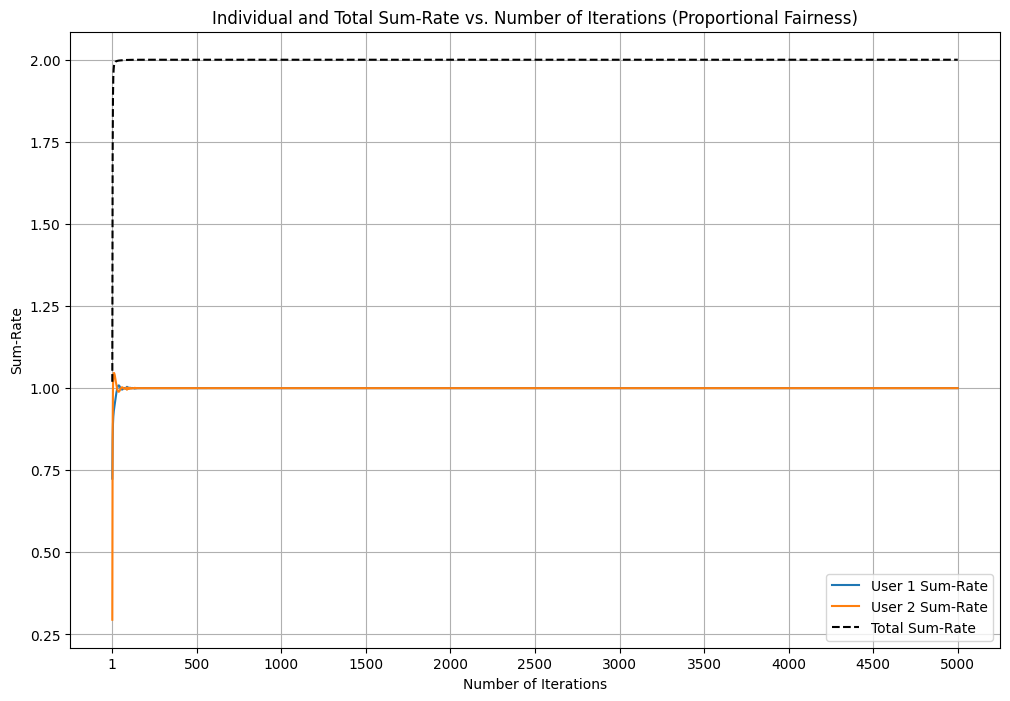

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt

# Set a fixed random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Define constants for noise power and number of users
NOISE_POWER = 1e-3  # Assume some noise power for simplicity
K = 2  # Number of users
T = 5000  # Number of iterations

# Encoder-Decoder Network
class EncoderDecoderModel(nn.Module):
    def __init__(self, Nt, Nr, d1, d2):
        super(EncoderDecoderModel, self).__init__()
        self.Nt = Nt
        self.Nr = Nr

        # Feature extraction layers for V and HV
        self.V_feature = nn.Linear(Nt * K, d1 * Nt * K)  # Adjust to match V dimensions
        self.HV_feature = nn.Linear(Nr * Nr, d2 * Nr * Nr)

        # MPNN Layers for learnable matrices
        self.fc1 = nn.Linear(d1 * Nt * K + d2 * Nr * Nr, 128)
        self.fc2 = nn.Linear(128, Nt * Nt)
        self.fc3 = nn.Linear(128, Nr * Nr)

    def forward(self, V, HV):
        # Flatten the matrices before passing through the layers
        V_flat = V.reshape(-1)
        HV_flat = HV.reshape(-1)

        # Extract features for V and HV
        V_feature = torch.relu(self.V_feature(V_flat))
        HV_feature = torch.relu(self.HV_feature(HV_flat))

        # Concatenate the features
        combined_features = torch.cat((V_feature, HV_feature), dim=-1)

        # Message Passing Neural Network (MPNN)
        x = torch.relu(self.fc1(combined_features))
        W_left = torch.relu(self.fc2(x)).reshape(self.Nt, self.Nt)
        W_right = torch.relu(self.fc3(x)).reshape(self.Nr, self.Nr)

        return W_left, W_right

# Update function for V
def update_precoding(V, H, W_left, W_right):
    return torch.matmul(torch.matmul(W_left, V), W_right)

# Sum-Rate per User Function
def sum_rate_per_user(V, H, power=1.0):
    user_sum_rates = []
    for k in range(K):  # Iterate over each user
        # Signal power for user k, scale by transmission power
        signal = torch.matmul(H[k], V[:, k].unsqueeze(1)) * power
        signal_power = torch.norm(signal) ** 2

        # Interference power from other users
        interference_power = sum(
            torch.norm(torch.matmul(H[j], V[:, k].unsqueeze(1))) ** 2 for j in range(K) if j != k
        )

        # SINR for user k
        sinr_k = signal_power / (interference_power + NOISE_POWER)

        # Rate for user k
        rate_k = torch.log2(1 + sinr_k)
        user_sum_rates.append(rate_k)

    # Return list of sum-rates for each user
    return user_sum_rates

# Function to run training and plot individual users' sum-rate and total sum-rate
def train_and_plot_sum_rate(Nt_fixed, Nr_fixed, d1_fixed, d2_fixed, power=1.0):
    plt.figure(figsize=(12, 8))

    # Initialize model and optimizer
    model = EncoderDecoderModel(Nt_fixed, Nr_fixed, d1_fixed, d2_fixed)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Example inputs (fixed initialization for reproducibility)
    V = torch.rand((Nt_fixed, K), requires_grad=True)  # Initial precoding matrix for K users (Nt, K)
    HV = torch.rand((Nr_fixed, Nr_fixed), requires_grad=True)  # Channel matrix
    H = torch.rand((K, Nr_fixed, Nt_fixed), requires_grad=True)  # Channel state for K users (K, Nr, Nt)

    # Store individual users' sum-rate for plotting
    user_sum_rates_over_iterations = [[] for _ in range(K)]
    total_sum_rate_over_iterations = []

    # Training loop
    for t in range(T):
        # Forward pass
        W_left, W_right = model(V, HV)

        # Update V using left and right learnable matrices
        V_updated = update_precoding(V, H, W_left, W_right)

        # Compute the sum-rate for each user with fixed power
        user_sum_rates = sum_rate_per_user(V_updated, H, power=power)

        # Store each user's sum-rate value for plotting
        for user_index in range(K):
            user_sum_rates_over_iterations[user_index].append(user_sum_rates[user_index].detach().numpy())

        # Compute the total sum-rate (sum of individual user rates)
        total_sum_rate = sum(user_sum_rates)
        total_sum_rate_over_iterations.append(total_sum_rate.detach().numpy())

        # Compute the fairness loss (negative geometric mean of sum-rates)
        fairness_loss = -torch.prod(torch.stack(user_sum_rates))  # Proportional Fairness Loss

        # Backpropagation to update model parameters
        optimizer.zero_grad()
        fairness_loss.backward(retain_graph=True)
        optimizer.step()

    # Plotting individual users' sum-rate vs Number of Iterations and total sum-rate
    for user_index in range(K):
        plt.plot(range(1, T + 1), user_sum_rates_over_iterations[user_index], label=f'User {user_index + 1} Sum-Rate')

    # Plot the total sum-rate
    plt.plot(range(1, T + 1), total_sum_rate_over_iterations, label='Total Sum-Rate', linestyle='--', color='black')

    # Labeling and displaying the plot
    plt.xlabel('Number of Iterations')
    plt.ylabel('Sum-Rate')
    plt.title('Individual and Total Sum-Rate vs. Number of Iterations (Proportional Fairness)')
    plt.xticks(ticks=[1] + list(range(500, T + 1, 500)))
    plt.legend()
    plt.grid(True)
    plt.show()

# Run the experiment for individual user sum-rate and total sum-rate
train_and_plot_sum_rate(Nt_fixed=8, Nr_fixed=2, d1_fixed=2, d2_fixed=4, power=1.0)
